# CLIP GradCAM Visualization

This notebook uses GradCAM on OpanAI's CLIP model to produce a heatmap highlighting which regions in an image activate the most to a given caption.

This only works with the ResNet variants. ViT support is on development.

## Imports

In [28]:
import json
import torch
import clip
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy.ndimage import gaussian_filter
from torch import nn
import nltk
from nltk.corpus import wordnet as wn


In [29]:
%matplotlib inline

nltk.download('wordnet')
print('\nLoading model...')
available_models = ['RN50', 'RN101', 'RN50x4', 'RN50x16']
layers = ['layer4', 'layer3', 'layer2', 'layer1']

clip_model = available_models[0]
saliency_layer = layers[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)
print(f"Done! Model loaded to {device} device")

[nltk_data] Downloading package wordnet to /home/lazye/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Loading model...
Done! Model loaded to cuda device


In [30]:
voc_class_fn = "./voc2012-original.json"

with open(voc_class_fn) as class_file:
    voc_class_json = json.load(class_file)
voc_classes = voc_class_json["classes"]

## Helper functions

Some helper functions for gettings CLIP scores, overlaying heatmaps on top of images and visualizing with matplotlib.

In [31]:
def get_scores(img_input, voc_classes):
    image_input = img_input
    text_inputs = torch.cat(
        [clip.tokenize(f"a photo of a {c}") for c in voc_classes]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(len(similarity[0]))
    scores = list()
    for value, index in zip(values, indices):
        scores.append((voc_classes[index], round(100 * value.item(), 2)))
    return scores


def get_top5(img_input, voc_classes):
    image_input = img_input
    text_inputs = torch.cat(
        [clip.tokenize(f"a photo of a {c}") for c in voc_classes]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    results = list()
    for value, index in zip(values, indices):
        # print(f"{voc_classes[index]:>16s}: {100 * value.item():.2f}%")
        results.append(f"{voc_classes[index]}: {100 * value.item():.2f}%")
    return results

In [32]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    return x / 0.6

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    img = img[:,:,:1]
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('plasma')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, title, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.show()

def save_attn(img, attn_map, title, fname, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.title(title)
    plt.savefig(fname, bbox_inches='tight')
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

### Synonyms helper class

In [33]:
class Allonyms:
    def __init__(self, word):
        self.word = word
        self.to_string = str()
        self.synms = set()
        self.simls = set()
        self.sees = set()
        self.hypos = set()
        self.hypers = set()
        self.allonyms = set()

    def update_word(self, word):
        self.word = word
        return self.word

    def grab_synms(self):
        for syn in wn.synsets(self.word):
            for lem in syn.lemmas():
                self.synms.add(lem.name())
        return self.synms

    def grab_sees(self):
        for syn in wn.synsets(self.word):
            for als in syn.also_sees():
                for lem in als.lemmas():
                    self.sees.add(lem.name())
        return self.sees

    def grab_simls(self):
        for syn in wn.synsets(self.word):
            for sims in syn.similar_tos():
                for lem in sims.lemmas():
                    self.simls.add(lem.name())
        return self.simls

    def grab_hypos(self):
        for syn in wn.synsets(self.word):
            for hypo in syn.hyponyms():
                for lem in hypo.lemmas():
                    self.hypos.add(lem.name())
        return self.hypos

    def grab_hypers(self):
        for syn in wn.synsets(self.word):
            for hype in syn.hypernyms():
                for lem in hype.lemmas():
                    self.hypers.add(lem.name())
        return self.hypers

    def grab_all(self):
        synms = self.grab_synms()
        sees = self.grab_sees()
        simls = self.grab_simls()
        hypos = self.grab_hypos()
        hypers = self.grab_hypers()
        self.allonyms = synms.union(sees, simls, hypos, hypers)
        return self.allonyms

    def parse_string(self):
        self.to_string += "{"
        self.to_string += f"'{self.word}',"
        for name in self.allonyms:
            self.to_string += f"'{name}',"
        self.to_string += "}\n"
        return self.to_string

    def to_file(self, filename):
        f = open(filename, 'a')
        f.write(self.to_string)
        f.close()
        return "ok"

    def all_to_file(self, filename):
        self.grab_all()
        self.parse_string()
        self.to_file(filename)


## GradCAM: Gradient-weighted Class Activation Mapping

Our gradCAM implementation registers a forward hook on the model at the specified layer. This allows us to save the intermediate activations and gradients at that layer.

To visualize which parts of the image activate for a given caption, we use the caption as the target label and backprop through the network using the image as the input. In the case of CLIP models with resnet encoders, we save the activation and gradients at the layer before the attention pool, i.e. layer4.

In [34]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

# Reference: https://arxiv.org/abs/1610.02391


def gradCAM(
        model: nn.Module,
        input: torch.Tensor,
        target: torch.Tensor,
        layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel dimension
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence
        # so we clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(gradcam,
                            input.shape[2:],
                            mode='bicubic',
                            align_corners=False)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
    
    return gradcam


In [35]:
count = 0

In [95]:
allo = Allonyms('skateboarder')
print(allo.grab_all())

{'skater', 'skateboarder'}


In [96]:
fname = 'biased/samples/skatist1.jpg'
label = 'skater'
target = 'skateboarder'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


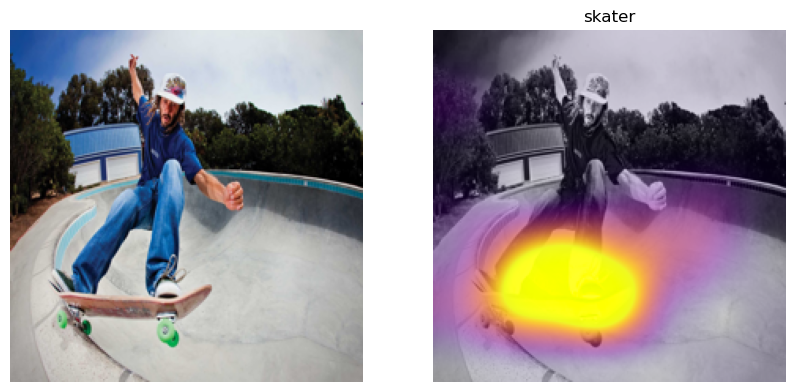

In [97]:
image_input = preprocess(Image.open(fname)).unsqueeze(0).to(device)
image_np = load_image(fname, model.visual.input_resolution)
text_input = clip.tokenize([f'a photo of a {label}']).to(device)
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()
viz_attn(image_np, attn_map, label, fname)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


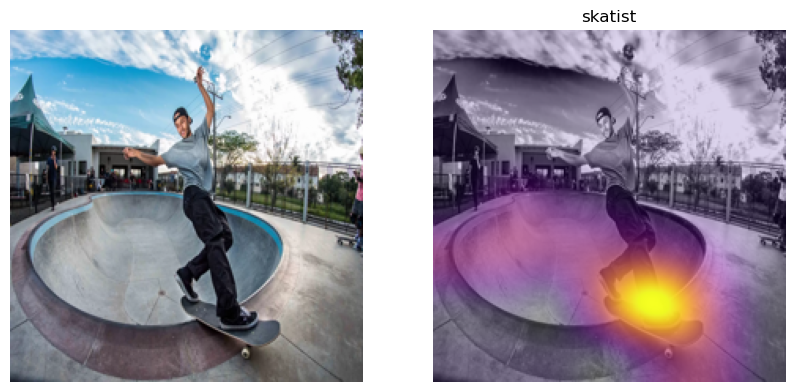

In [86]:
#save_attn(img, attn_map, title, fname, blur=True)
count += 1
save_attn(image_np, attn_map, label, f'biased/heatmaps/{label}-heatmap{count}{count}.jpg')

In [70]:
label = 'rider'

In [68]:
new_voc = list()
for name in voc_classes:
    if name == target:
        new_voc.append(label)
    else:
        new_voc.append(name)

In [69]:
print(get_top5(image_input, new_voc))

['a male cyclist: 97.61%', 'motorbike: 1.65%', 'aeroplane: 0.17%', 'car: 0.13%', 'person: 0.11%']


In [51]:
print(get_top5(image_input, voc_classes))

['bicycle: 92.14%', 'motorbike: 5.45%', 'aeroplane: 0.57%', 'car: 0.44%', 'person: 0.37%']


We'll run a for loop where each run the target label will be replaced by one of it's synonyms. We will then generate scores based on similarity, and heatmaps based on activation maps. 

In [23]:
label = 'rider'
img_num = 4
allo = Allonyms(label)
synms = allo.grab_all()
image_path = f'./classes/{label}/imgs/{label}{img_num}.jpg'
image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)

atn_maps = dict()

d = {
    'label': list(),
    'synonym': list(),
    'attnMap': list(),
    'sim_score': list(),
    'position': list(),
    'first': list()
}

for syn in synms:
    d['label'].append(label)
    d['synonym'].append(syn)
    text_input = clip.tokenize([f'a photo of a {syn}']).to(device)
    new_classes = list()
    syn_added = 0
    for name in voc_classes:
        if name == label:
            new_classes.append(syn)
            syn_added = 1
        else:
            new_classes.append(name)
    
    if not syn_added:
        new_classes.append(syn)
    
    attn_map = gradCAM(
        model.visual,
        image_input,
        model.encode_text(text_input).float(),
        getattr(model.visual, saliency_layer)
    )
    attn_map = attn_map.squeeze().detach().cpu().numpy()
    atn_maps[syn] = attn_map
    x = gaussian_filter(attn_map, 0.02*max(image_np.shape[:2]))
    x = x - x.min()
    d['attnMap'].append(x.max())
    
    scores = get_scores(image_input, new_classes)
    first = scores[0][0]
    if first == syn:
        d['first'].append('same')
    else:
        d['first'].append(first)

    for i, cls in enumerate(scores):
        if syn == cls[0]:
            d['position'].append(i+1)
            d['sim_score'].append(cls[1])
            break


KeyboardInterrupt: 

After all the synonyms have been processed, we will transform our dictionary of lists into a `pandas.DataFrame`, initially sorting its records by **similarity score**.

In [ ]:
df = pd.DataFrame(data=d)
df = df.sort_values(by=['sim_score'], ascending=False)

csv_path = Path(f'./classes/{label}/results/{label}{img_num}-synms.csv')
csv_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(csv_path, index=False)

In [ ]:
df.head(5)

,label,synonym,attnMap,sim_score,position,first
9,rider,pedaller,0.310203,99.12,1,same
8,rider,rider,0.267726,94.68,1,same
10,rider,pedaler,0.256367,67.97,1,same
4,rider,commuter,0.173882,20.73,2,bicycle
1,rider,horseman,0.154078,6.02,2,bicycle


In order to better visualize and understand the model predictions, we will display the input image with the first and last record heatmap.

In [ ]:
tail = df.tail(1)['synonym'].values[0]
head = df.head(1)['synonym'].values[0]

In [ ]:
heat_path = Path(f'./classes/{label}/heatmaps/none.txt')
heat_path.parent.mkdir(parents=True, exist_ok=True)

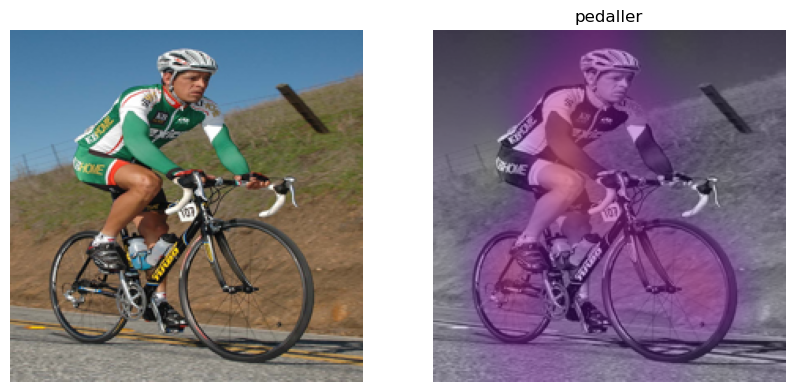

In [ ]:
head_name = f"./classes/{label}/heatmaps/{head}-top1-sim-{label}{img_num}.png"
save_attn(image_np, atn_maps[head], head, head_name, blur)

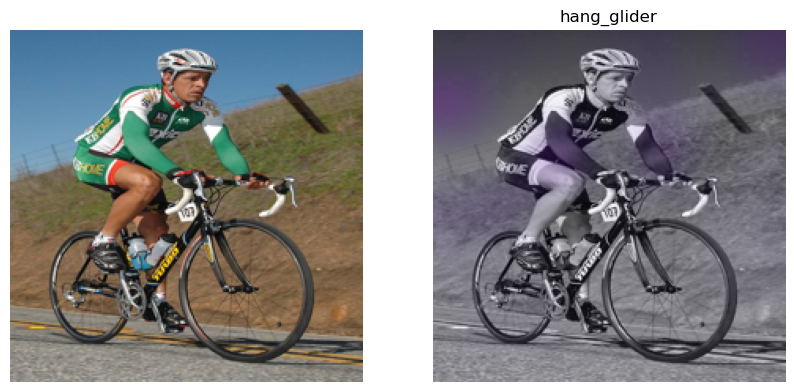

In [ ]:
tail_name = f"./classes/{label}/heatmaps/{tail}-bot1-sim-{label}{img_num}"
save_attn(image_np, atn_maps[tail], tail, tail_name, blur)

Oddly enough, the synonym with the highest similarity score is not always the same record with the highest attention map. So we will reorder the results by attention map in order to evaluate.

In [ ]:
df = df.sort_values(by=['attnMap'], ascending=False)
df.head()

,label,synonym,attnMap,sim_score,position,first
9,rider,pedaller,0.310203,99.12,1,same
8,rider,rider,0.267726,94.68,1,same
10,rider,pedaler,0.256367,67.97,1,same
4,rider,commuter,0.173882,20.73,2,bicycle
11,rider,hitchhiker,0.157547,5.43,2,bicycle


In [ ]:
tail = df.tail(1)['synonym'].values[0]
head = df.head(1)['synonym'].values[0]

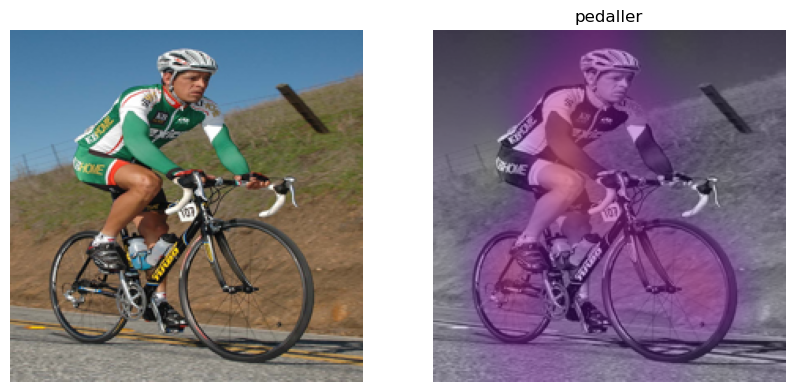

In [ ]:
head_name = f"./classes/{label}/heatmaps/{head}-top1-attn-{label}{img_num}.png"
save_attn(image_np, atn_maps[head], head, head_name, blur)

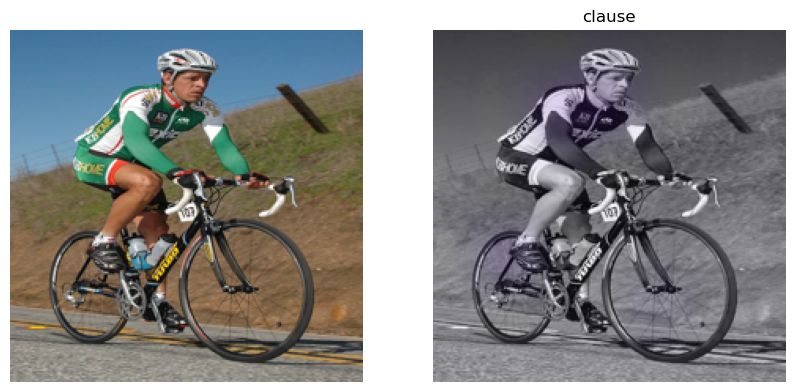

In [ ]:
tail_name = f"./classes/{label}/heatmaps/{tail}-bot1-attn-{label}{img_num}.png"
save_attn(image_np, atn_maps[tail], tail, tail_name, blur)